In [2]:
%%html
<style type='text/css'>
@font-face {
    font-family: 'ParisineBold'; 
    src: url('assets/Parisine\ Bold.otf');
}

body{
    font-family: 'ParisineBold';
    color: #284897 !important;
    background-color: white;
}

</style>

# Analyser les données
Si lors de la partie du scraping, on se contentait uniquement de récupérer la données, ici l'objectif sera de la traiter pour la rendre accessible et ainsi faire des analyses dessus. Car en l'état un tweet est très peu exploitable, de la même manière qu'on ne veut pas de tout les tweets récoltés, mais seulement une portion : ceux parlant des incidents.


## Mise en place

In [3]:
import pandas as pd
import uuid
import requests
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk import ngrams
import unicodedata
import re
from collections import Counter
import string
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import numpy as np
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gabriel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
def concat_all_parts(*args):
    dataframes = []
    for file in args:
        df = pd.read_csv(file)
        df['content'] = df['content'].astype(str)
        dataframes.append(df)
    combined_df = pd.concat(dataframes, ignore_index=True)
    return combined_df

# Exemple d'utilisation
#df_f = concat_all_parts('../scraper/data/part1.csv', '../scraper/data/part2.csv', '../scraper/data/part3.csv')
df_f = concat_all_parts('../scraper/data/part1V3.csv', '../scraper/data/part2V3.csv', '../scraper/data/part3V3.csv', '../scraper/data/part4V3.csv', '../scraper/data/part5V3.csv')
df_f.reset_index(drop=True, inplace=True)

print(df_f.shape)
df_f.drop_duplicates(subset=['content', 'time_posted'], inplace=True)
print(df_f.shape)

(6254, 9)
(6177, 9)


Ici on créer un dictionnaire qui, pour chacune des gares de la ligne du RER A associe toutes les manières de l'écrire possible. Par exemple Boissy-Saint-Léger peut aussi être écrit comme Boissy-St-Léger, ce sont 2 orthographes différentes pour une même gare ; on répète ce processus pour toutes les gares.
Ce dictionnaire permettra de facilement trouver la gare mentionnée dans un tweet.

De telles méthodes statiques sont employées car les tweets du compte sont très formattés, et les formulations se répètent très souvent, on peut donc se permettre de telles solutions.

In [5]:
stations_rer_a_constant_dict = {
    "Achères Grand Cormier":["Achères Grand Cormier"],
    "Achères Ville" : ["Achères Ville", "Achères"],
    "Auber" : ["Auber"],
    "Boissy-Saint-Léger" : ["Boissy-Saint-Léger", "Boissy-St-Léger", "Boissy", "Poissy Saint Léger"],
    "Bry-sur-Marne": ["Bry-sur-Marne"],
    "Bussy-Saint-Georges": ["Bussy-Saint-Georges", "Bussy-St-Georges", "Bussy"],
    "Cergy le Haut" : ["Cergy le Haut", "Cergy"],
    "Cergy Préfecture" : ["Cergy Préfecture"],
    "Cergy Saint-Christophe" : ["Cergy Saint-Christophe", "Cergy St-Christophe"],
    "Champigny": ["Champigny"],
    "Charles de Gaulle-Etoile" : ["Charles de Gaulle-Etoile", "Ch. de Gaulle–Étoile"],
    "Châtelet les Halles" : ["Châtelet les Halles"],
    "Chatou-Croissy" : ["Chatou-Croissy"],
    "Conflans Fin d'Oise" : ["Conflans Fin d'Oise", "Conflans – Fin d’Oise"],
    "Fontenay-sous-Bois" : ["Fontenay-sous-Bois", "Fontenay"],
    "Gare de Lyon" : ["Gare de Lyon"],
    "Houilles-Carrières-sur-Seine" : ["Houilles-Carrières-sur-Seine", "Houilles"],
    "Joinville-le-Pont" : ["Joinville-le-Pont", 'Joinville'],
    "La Défense" : ["La Défense", "Défense"],
    "La Varenne-Chennevières" :["La Varenne-Chennevières", "Varenne-Chennevières", "Varennes Chennevieres"],
    "Parc de Saint-Maur" : ["Parc de Saint-Maur", "Parc de St-Maur", "Parc Saint-Maur", "Parc St-Maur", "Parc Saint - Maur"],
    "Le Vésinet-Centre" : ["Le Vésinet-Centre", "Vésinet-Centre"],
    "Le Vésinet-Le Pecq" : ["Le Vésinet-Le Pecq", "Vésinet-Le Pecq"],
    "Lognes": ["Lognes"],
    "Maisons-Laffitte" : ["Maisons-Laffitte", "Maison-Laffitte", "Maisons-Laffite", "Maison-Laffite"],
    "Marne-la-Vallée-Chessy" : ["Marne-la-Vallée-Chessy", "MLV-Chessy", "Marne la Vallée", "Chessy"],
    "Nanterre Préfecture" : ['Nanterre Préfecture', "Nantere Pref", "Nanterre-P"],
    "Nanterre Université" : ["Nanterre Université"],
    "Nanterre Ville" : ["Nanterre Ville"],
    "Nation" : ["Nation"],
    "Neuilly-Plaisance" : ["Neuilly-Plaisance"],
    "Neuville Université": ["Neuville Université"],
    "Nogent-sur-Marne" : ["Nogent-sur-Marne"],
    "Noisiel" : ["Noisiel"],
    "Noisy-Champs" : ["Noisy-Champs"],
    "Noisy-le-Grand-Mont d'Est" : ["Noisy-le-Grand-Mont d'Est", "Noisy-le-Grand"],
    "Poissy" : ["Poissy"],
    "Rueil-Malmaison" : ["Rueil-Malmaison"],
    "Saint-Germain-en-Laye" : ["Saint-Germain-en-Laye", "St-Germain-En-Laye", "St Germain", "Saint Germain"],
    "Saint-Maur-Créteil" : ["Saint-Maur-Créteil", "St-Maur-Créteil"],
    "Sartrouville" : ["Sartrouville"],
    "Sucy-Bonneuil" : ["Sucy-Bonneuil"],
    "Torcy" : ["Torcy"],
    "Val d'Europe" : ["Val d'Europe"],
    "Val de Fontenay" : ["Val de Fontenay"],
    "Vincennes" : ["Vincennes"],
}

In [6]:
print(df_f.shape)
df_f.dropna(subset=['thread_id'], inplace=True)
print(df_f.shape)

(6177, 9)
(6158, 9)


In [7]:
quote_tweet = df_f[df_f['content'].str.contains("Citation du tweet")]

for index, row in df_f.iterrows():
    if "Citation du tweet" in row['content']:
        date_included = re.search(r'tweet du (.*)', row["content"]).group(1)
        current_thread_id = row["thread_id"]
        try:
            new_threa_id = df_f[df_f['time_posted'] == date_included]['thread_id'].values[0]
            df_f.loc[df_f['thread_id'] == current_thread_id, 'thread_id'] = new_threa_id
        except:
            #df_f.loc[df_f['thread_id'] == current_thread_id, 'thread_id'] = "null"
            df_f.drop(index, inplace=True)
            #raise("ta grand mere")


In [8]:
print(df_f.shape)

(6152, 9)


## Nettoyage
Après avoir importé les données et créé un premier référentiel, il est temps de nettoyer les données.
Les étapes de nettoyage seront décrite au fur et à mesure.

### Création d'une fonction de nettoyage
Pour simplifier le processus, une fonction est créée rassemblant les étapes principales du nettoyage de données. On y retrouve la mise en minuscule, la normalisation en remplacant les caractères accentués, retirer les chiffres ou espaces supllémentaires...
Cette première fonction permettra de mettre les données à un même stade.

In [9]:
def clean_text(text):
    text = text.lower()
    text = text.replace('–', '-')
    text = text.replace('\n', ' ')
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode("utf-8")
    text = re.sub(r'[^\w\s]',' ',text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s{2,}', ' ', text)
    return text

### Nettoyer le réferentiel
Comme le référentiel des gares n'est pas totalement propre, il passe par la fonction de nettoyage, de cette manière lorsqu'on nettoiera les données de tweet, les différentes orthographes de gares auront les mêmes caractéristiques.

In [10]:
stations_rer_a_cleaned_dict = stations_rer_a_constant_dict.copy()
for key, value in stations_rer_a_cleaned_dict.items():
    stations_rer_a_cleaned_dict[key] = [clean_text(station) for station in value]
df_f['content_cleaned'] = df_f['content'].apply(clean_text)

In [11]:
stations_rer_a_cleaned_dict

{'Achères Grand Cormier': ['acheres grand cormier'],
 'Achères Ville': ['acheres ville', 'acheres'],
 'Auber': ['auber'],
 'Boissy-Saint-Léger': ['boissy saint leger',
  'boissy st leger',
  'boissy',
  'poissy saint leger'],
 'Bry-sur-Marne': ['bry sur marne'],
 'Bussy-Saint-Georges': ['bussy saint georges', 'bussy st georges', 'bussy'],
 'Cergy le Haut': ['cergy le haut', 'cergy'],
 'Cergy Préfecture': ['cergy prefecture'],
 'Cergy Saint-Christophe': ['cergy saint christophe', 'cergy st christophe'],
 'Champigny': ['champigny'],
 'Charles de Gaulle-Etoile': ['charles de gaulle etoile',
  'ch de gaulle etoile'],
 'Châtelet les Halles': ['chatelet les halles'],
 'Chatou-Croissy': ['chatou croissy'],
 "Conflans Fin d'Oise": ['conflans fin d oise', 'conflans fin doise'],
 'Fontenay-sous-Bois': ['fontenay sous bois', 'fontenay'],
 'Gare de Lyon': ['gare de lyon'],
 'Houilles-Carrières-sur-Seine': ['houilles carrieres sur seine', 'houilles'],
 'Joinville-le-Pont': ['joinville le pont', 'jo

### Détecter les gares
L'objectif du référentiel est de pouvoir retrouver les gares mentionnées dans les tweets. Eh bien, c'est ce qui va être fait ici !
Comme plusieurs gares peuvent apparaître dans un tweet, il est nécessaire d'itérer sur toutes les gares du référentiel et de noter la clé du dictionnaire associés comme occurrence.
Le problème avec ça est que par exemple dans le cas où la gare "Boissy Saint Léger" est mentionnée, comme dans ses appellations il y a "Boissy" et "Boissy Saint Léger" on peut voir qu'une possibilité d'occurrence est contenue dans l'autre. C'est à dire que pour cette gare on comptera 2 occurrences. (Exemple : "Un incident est survenue à la gare de Boissy Saint Léger", dans le référentiel pour cette gare il y a "Boissy" et "Boissy Saint Léger", et ces 2 possibilités existent dans le texte, il faut trouver le moyen d'itérer qu'une seule fois)

Pour éviter ce problème, la solution employée (qui n'est pas la plus optimale) et de vérifier le contenu du texte à l'aide d'une fénetre s'étendant d'un caractère vers la droite tant que rien n'est trouvé. Si une gare est trouvée dans cette fenêtre, on note la gare, et la nouvelle fenêtre de recherche commencera à la fin de la gare trouvée. De cette manière on évite d'itérer sur une gare déjà trouvée.


#### Tester la fonction de fenêtrage

In [12]:
current_text = "les trains actuellement entre bussy saint georges et marne la vallee chessy et en direction de marne la vallee chessy stationnent en raison d une panne electrique a marne la vallee chessy rera"

cursor_deb = 0
cursor_end = 1


def find_gare(text):
    for gare_key in stations_rer_a_cleaned_dict.keys():
        for gare2 in stations_rer_a_cleaned_dict[gare_key]:
            if gare2 in text:
                return gare2, gare_key
    return None, None


def find_max_len_gare_from_key(gare_key, gare_matched, text, cursor_deb, cursor_end):
    current_len = len(gare_matched)

    temp_list = stations_rer_a_cleaned_dict[gare_key].copy()
    temp_list.sort(key=len, reverse=True)
    max_len_gare = temp_list[0]
    diff_len = len(max_len_gare) - current_len

    cursor_end2 = cursor_end + diff_len

    new_text = text[cursor_deb:cursor_end2]
    for gare in temp_list:
        if gare in new_text:
            return gare, cursor_end2
                

while cursor_end < len(current_text):

    ## Find gare between cursor_deb and cursor_end
    gare, gare_key = find_gare(current_text[cursor_deb:cursor_end])

    if gare is None:
        cursor_end += 1
    else:
        gare, cursor_end = find_max_len_gare_from_key(gare_key, gare, current_text, cursor_deb, cursor_end)
        print(gare)
        cursor_deb = cursor_end
        cursor_end = cursor_deb + 1 
                
                

bussy saint georges
marne la vallee chessy
marne la vallee chessy
marne la vallee chessy


#### Application de la fonction de fenêtrage

In [13]:
for index, row in df_f.iterrows():
    current_text = row['content_cleaned']
    cursor_deb = 0
    cursor_end = 1

    gare_detected = []

    while cursor_end < len(current_text):

        gare, gare_key = find_gare(current_text[cursor_deb:cursor_end])

        if gare is None:
            cursor_end += 1
        else:
            gare, cursor_end = find_max_len_gare_from_key(gare_key, gare, current_text, cursor_deb, cursor_end)
            gare_detected.append(gare_key)
            cursor_deb = cursor_end
            cursor_end = cursor_deb + 1 

    df_f.loc[index, 'gare_detected'] = ",".join(gare_detected)


Pour constater les résultats, on peut regarder le nombre de gares mentionnées selon le type de tweets.

In [14]:
df_f['nb_gare_detected'] = df_f['gare_detected'].apply(lambda x: len(x.split(',')))
df_f.groupby(['tweet_type', 'nb_gare_detected']).size()

tweet_type  nb_gare_detected
Normal      1                    130
            2                   1306
            3                    567
            4                    146
            5                     39
            6                      9
            7                      1
Réponse     1                    961
            2                   1496
            3                    933
            4                    368
            5                    149
            6                     45
            7                      2
dtype: int64

In [15]:

"""
for index, row in df_f.iterrows():
    tweet_text = row['content_cleaned']
    tweet_len = len(tweet_text)

    cursor_begin = 0
    cursor_end = 0

    gare_detec = []

    while cursor_end <= tweet_len:
        current_text = tweet_text[cursor_begin:cursor_end]

        for gare_key in stations_rer_a_cleaned_dict.keys():

            gare = ""
            # marne la vallee chessy ne matche pas alors que, marne la vallee et chessy matchent
            for gare2 in stations_rer_a_cleaned_dict[gare_key]:
                if gare2 in current_text:
                    gare = gare2
                    if tweet_text == "les trains actuellement entre bussy saint georges et marne la vallee chessy et en direction de marne la vallee chessy stationnent en raison d une panne electrique a marne la vallee chessy rera":
                        print(gare)
                    break

            if gare == "":
                continue
                    
            temp_list = stations_rer_a_cleaned_dict[gare_key].copy()
            temp_list.sort(key=len, reverse=True)
            
            max_len_gare = len(temp_list[0])
            diff_len = max_len_gare - len(gare)

            best_gare_name_len = 0
            best_gare_name = ""
            for gare2 in stations_rer_a_cleaned_dict[gare_key]:
                if gare2 in tweet_text[cursor_begin:cursor_end+diff_len]:
                    if len(gare2) > best_gare_name_len:
                        best_gare_name_len = len(gare2)
                        best_gare_name = gare2

                
            gare_detec.append(gare_key)
            cursor_begin = cursor_end+(max_len_gare-len(best_gare_name))
                    

        cursor_end += 1
    df_f.loc[index, 'gare_detected'] = ",".join(gare_detec)
"""

'\nfor index, row in df_f.iterrows():\n    tweet_text = row[\'content_cleaned\']\n    tweet_len = len(tweet_text)\n\n    cursor_begin = 0\n    cursor_end = 0\n\n    gare_detec = []\n\n    while cursor_end <= tweet_len:\n        current_text = tweet_text[cursor_begin:cursor_end]\n\n        for gare_key in stations_rer_a_cleaned_dict.keys():\n\n            gare = ""\n            # marne la vallee chessy ne matche pas alors que, marne la vallee et chessy matchent\n            for gare2 in stations_rer_a_cleaned_dict[gare_key]:\n                if gare2 in current_text:\n                    gare = gare2\n                    if tweet_text == "les trains actuellement entre bussy saint georges et marne la vallee chessy et en direction de marne la vallee chessy stationnent en raison d une panne electrique a marne la vallee chessy rera":\n                        print(gare)\n                    break\n\n            if gare == "":\n                continue\n                    \n            temp

In [16]:
"""df_f['gare_detected'] = ""
for index, row in df_f.iterrows():
    gare_detec = []

    tweet_text = row['content_cleaned']
    for gare_key in stations_rer_a_cleaned_dict.keys():
        for gare in stations_rer_a_cleaned_dict[gare_key]:
            if gare in row['content_cleaned']:
                gare_detec.append((gare, gare_key))
            break

    details = []
    for gare_detected in gare_detec:
        index_deb = tweet_text.find(gare_detected[0])
        index_fin = index_deb + len(gare_detected[0])

        details.append((gare_detected, index_deb, index_fin))

    details = sorted(details, key=lambda x: x[1])

    details_copy = details.copy()

    print(details)
    for index, detail in enumerate(details[1:]):
        index_deb = detail[1]
        index_fin = detail[2]

        old_deb = details[index][1]
        old_fin = details[index][2]   

        if index_deb >= old_deb and index_fin <= old_fin:
            details_copy.remove(detail)
        
    print(details_copy)

    final_gare_detec = [detail[0][1] for detail in details_copy]
    df_f.loc[index, 'gare_detected'] = ",".join(final_gare_detec)"""

'df_f[\'gare_detected\'] = ""\nfor index, row in df_f.iterrows():\n    gare_detec = []\n\n    tweet_text = row[\'content_cleaned\']\n    for gare_key in stations_rer_a_cleaned_dict.keys():\n        for gare in stations_rer_a_cleaned_dict[gare_key]:\n            if gare in row[\'content_cleaned\']:\n                gare_detec.append((gare, gare_key))\n            break\n\n    details = []\n    for gare_detected in gare_detec:\n        index_deb = tweet_text.find(gare_detected[0])\n        index_fin = index_deb + len(gare_detected[0])\n\n        details.append((gare_detected, index_deb, index_fin))\n\n    details = sorted(details, key=lambda x: x[1])\n\n    details_copy = details.copy()\n\n    print(details)\n    for index, detail in enumerate(details[1:]):\n        index_deb = detail[1]\n        index_fin = detail[2]\n\n        old_deb = details[index][1]\n        old_fin = details[index][2]   \n\n        if index_deb >= old_deb and index_fin <= old_fin:\n            details_copy.remove

### Retirer les mots sans importance
Pour continuer l'étude du contenu, il est temps de maintenant retirer les mots sans importance des tweets, ceux qui n'apportent pas de sémantique.
Si la liste de stopowrds français est assez exhaustive et permet de retirer la majorité des mots inutiles des tweets, cette liste ne contient pas tout. Dans le contexte de la rechercher des incidents du RER A, d'autres mots sont nécessaires à exclure, comme par exemple : rera, actuellement, direction, train... Des mots qui dans le contexte du RER A apparaissent très régulièrement, mais n'apportent pas grand choses puisqu'ici on sait que nos données sont cadrées dans la thématique des incidents.

In [17]:
stopwords_list = stopwords.words('french')+['a', 'rera', 'actuellement', 'direction', 'vers', 'trafic', 'repercussion', "train", "trains", "paris", "h", "cela", "fait", "suite", 'entre']


critical_words = ['perturbe', 'raison', 'stationne', 'rer_a', 'entre', 'gare', 'marquent', 'arret', 'autre', 'heure', 'reprise', 'estimee', 'ensemble', 'ligne', 'prolonge', 'reste', 'interrompu', 'stationnent', 'stationnement', 'repart', 'terminus', 'desservie', 'jo2024']

stopwords_list = stopwords_list #+ critical_words

def remove_stations(text):
    for gare_key in stations_rer_a_cleaned_dict:
        for station in stations_rer_a_cleaned_dict[gare_key]:
            text = text.replace(station, '')
    return text

def remove_stopwords(text):
    text = ([word for word in text.split() if word not in stopwords_list])
    return text


df_f['content_removed_gare'] = df_f['content_cleaned'].apply(remove_stations)
df_f['content_removed_sw'] = df_f['content_removed_gare'].apply(remove_stopwords)
df_f['content_cleand_str'] = df_f['content_removed_sw'].apply(lambda x:' '.join(x))

## Observation des mots
Avant d'aller plus loin dans l'analyse, il est pertinent de faire une première observation sur le contenu de tous les tweets confondus. Pour voir la fréquences des mots utilisés, et par la même occasion vérifier qu'il ne reste pas de stopwords à retirer.
Pourquoi observer les mots ? Eh bien, pour l'instant il n'y a aucun moyen de savoir si un tweet parle d'un incident ou non, le seul moyen de différencier est le champ lexical utilisé pour les tweets en questions.

In [18]:
def count_bigrams(df, column_name):
    # Initialiser un compteur pour les bigrammes
    bigram_counter = Counter()
    
    # Parcourir chaque ligne de la colonne spécifiée
    for text in df[column_name]:
        # Tokenizer le texte en mots
        tokens = nltk.word_tokenize(text)
        
        # Générer les bigrammes
        bigrams = ngrams(tokens, 2)
        
        # Mettre à jour le compteur de bigrammes
        bigram_counter.update(bigrams)
    
    return bigram_counter
def count_trigrams(df, column_name):
    # Initialiser un compteur pour les bigrammes
    trigram_counter = Counter()
    
    # Parcourir chaque ligne de la colonne spécifiée
    for text in df[column_name]:
        # Tokenizer le texte en mots
        tokens = nltk.word_tokenize(text)
        
        # Générer les bigrammes
        trigrams = ngrams(tokens, 3)
        
        # Mettre à jour le compteur de bigrammes
        trigram_counter.update(trigrams)
    
    return trigram_counter

def count_words(df, column_name):
    # Initialiser un compteur pour les bigrammes
    words_counter = Counter()
    
    # Parcourir chaque ligne de la colonne spécifiée
    for text in df[column_name]:
        # Tokenizer le texte en mots
        tokens = nltk.word_tokenize(text)
        
        # Générer les bigrammes
        words = ngrams(tokens, 1)
        
        # Mettre à jour le compteur de bigrammes
        words_counter.update(words)
    
    return words_counter

bigram_counter = count_bigrams(df_f, 'content_cleand_str')
trigram_counter = count_trigrams(df_f, 'content_cleand_str')
word_counter = count_words(df_f, 'content_cleand_str')  


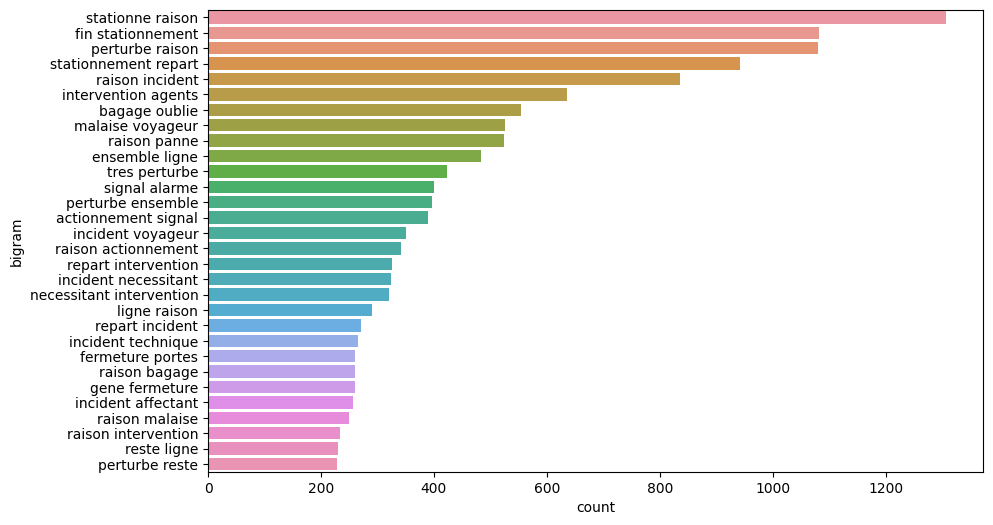

In [19]:
bigrams, counts_bigram = zip(*bigram_counter.most_common(30))
bigrams = [' '.join(bigram) for bigram in bigrams]
df_bigrams = pd.DataFrame({'bigram': bigrams, 'count': counts_bigram})


plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='bigram', data=df_bigrams);

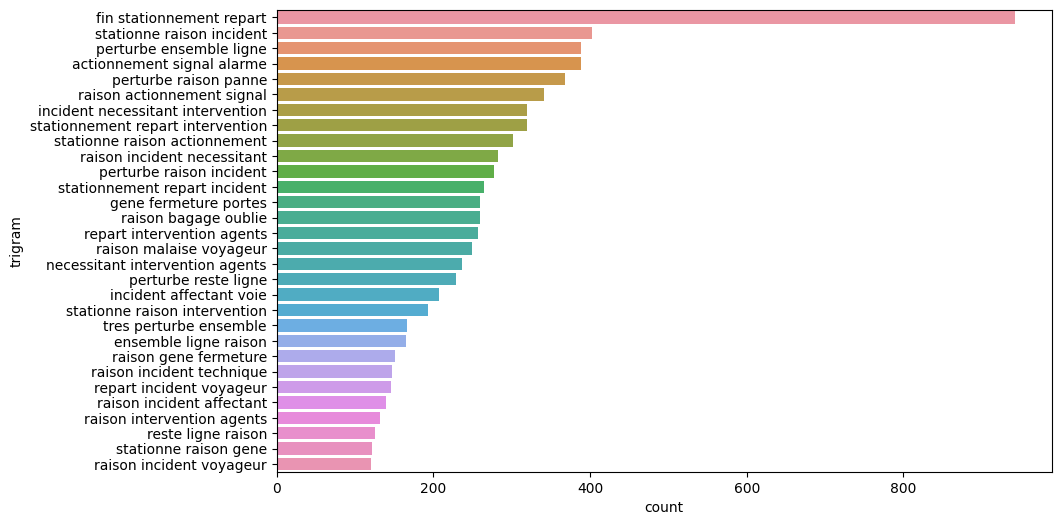

In [20]:
import matplotlib.cm as cm
import numpy as np

trigrams, counts_trigram = zip(*trigram_counter.most_common(30))
trigrams = [' '.join(trigram) for trigram in trigrams]

df_trigrams = pd.DataFrame({'trigram': trigrams, 'count': counts_trigram})

plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='trigram', data=df_trigrams);


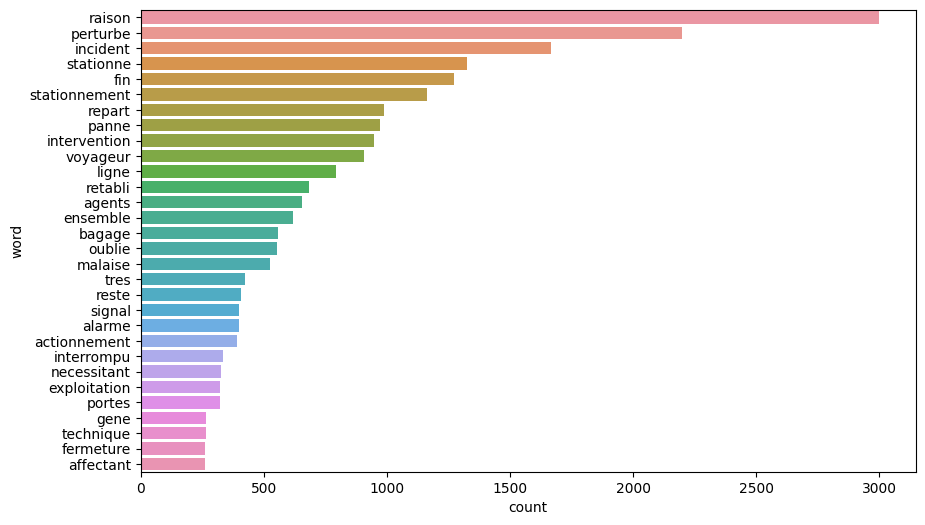

In [21]:
import matplotlib.cm as cm
import numpy as np

words, counts_words = zip(*word_counter.most_common(30))
words = [' '.join(word) for word in words]

df_words = pd.DataFrame({'word': words, 'count': counts_words})

plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='word', data=df_words);


Ces 3 graphs nous donnent des informations extrêmement importantes quant aux mots/bigram/trigram les plus utilisés : les résultats sont plutot encourageants, puisqu'on voit directement une tendance se dessiner, celle-ci clairement articulée autour des incidents avec des mots comme : bagage oublie, malaise voyageur, signal alarme... Ce qui veut dire que la majorité des tweets contiennent des mots realtifs aux incidents, on est donc dans la bonne direction.

## Trier les tweets des incidents de ceux de sujets divers
L'étude des mots les plus courants peut nous aider dans cette tâche qui va être de séparer les tweets sur les incidents (qu'on souhaite garder) et ceux n'ayant pas les incidents pour thématiques (ceux dont on n'a pas besoin). A cette étape plusieurs solutions sont envisageables : clustering, les transformer (modèle)... Ici je vais utiliser une liste de termes que je vais affiner petit à petit pour être sûr d'includre/exclure les tweets voulus, étant donné que les tweets sont très formattés on peut se permettre une telle solution.

On va donc définir 2 listes de termes : une contenant des mots relatif aux incidents, une autres contenant des mots relatifs aux tweets divers. Si un tweet "principal" contient les mots d'une liste ou l'autre, on l'associe à la catégorie associée. Dans le cas où il ne correspond à aucune liste, cela ne change rien puisque cela signifiera qu'il est inutile. On aurait pu définir uniquement une liste de termes (celle des incidents), mais pour s'assurer des mauvais tweet la deuxième liste a été définie, car ces mauvais tweets sont eux aussi très reconnaissable.

In [22]:
df_tweet_normal = df_f[df_f['tweet_type']=='Normal']

words_problem = ['incident','stationne', 'oublie', 'perturbe', 'altercation', 'bagarre', 'alarme', 'intervention', 'voie', 'personne', 'malaise', 'inondations', 'panne', 'gene', 'fermeture', 'porte', 'difficulte', 'exploitation', 'rallongement', 'chantier', 'affluence', 'exceptionnelle', 'prefecture', 'police', 'catenaire', 'intervalle', 'retardee', 'degradation', 'regulation', 'fumee', 'securite', 'malveillance', 'travaux urgents', 'changement', 'interrompu']


words_not_problem = ['mardiconseil', 'nouvelarticle', 'nouvel article','jeudiphoto', 'vendredilecture', 'jeu concours', 'hydrater', 'philosopher', 'solliciter', 'respecter', 'animation', 'tchat', 'blog', 'voir plus']

df_f['is_problem'] = False
for i, row in df_f.iterrows():
    if row['tweet_type']=='Normal':
        for word in words_problem:
            if word in row['content_cleand_str']:
                tweet_id = df_f.loc[i, 'thread_id']
                df_f.loc[df_f['thread_id']==tweet_id, 'is_problem'] = True

        for word in words_not_problem:
            if word in row['content_cleand_str']:
                tweet_id = df_f.loc[i, 'thread_id']
                df_f.loc[df_f['thread_id']==tweet_id, 'is_problem'] = False

Pour affiner l'une des listes de termes, on peut visionner les tweets d'une catégorie ou d'une autre.

In [23]:
df_f[(df_f['tweet_type']=='Normal') & (df_f['is_problem']==False)][['content', 'content_cleand_str']].values

array([['Image Image', 'image image'],
       [' Rénovation du MI2N', 'renovation min'],
       ['Image', 'image'],
       ['Image', 'image'],
       ['Image', 'image'],
       ['Image', 'image'],
       ['Image', 'image'],
       ['rera-leblog.fr rera-leblog.fr Objet délaissé : trafic inévitablement perturbé ! Objet délaissé : trafic inévitablement perturbé ! « Le train actuellement à Nation en direction de Poissy stationne en raison d’un objet délaissé. » Vous avez déjà pu recevoir ce genre de notification si vous êtes abonné au fil X (anciennement... « Le train actuellement à Nation en direction de Poissy stationne en raison d’un objet délaissé. » Vous avez déjà pu recevoir ce genre de notification si vous êtes abonné au fil X (anciennement...',
        'leblog fr leblog fr objet delaisse inevitablement perturbe objet delaisse inevitablement perturbe stationne raison dun objet delaisse deja pu recevoir genre notification si etes abonne fil x anciennement stationne raison dun objet d

## Statistiques générales des tweets
Maintenant que chaque tweet est catégorisé selon s'il contient des informations relatives à des incidents, on peut analyser les données de manière plus générales.

### Fréquence de tweet et visibilité
Commencons par la fréquences des tweets ainsi que le nombre de vues de chacun

In [24]:
df_f['date'] = pd.to_datetime(df_f['time_posted'])
start_date = df_f['date'].min()
end_date = df_f['date'].max()

print(f"Période de temps maximale : du {start_date} au {end_date}")

Période de temps maximale : du 2024-01-01 05:04:34 au 2024-12-01 00:08:55


In [25]:
# Compter le nombre de tweets par jour
df_tweet_normal = df_f[df_f['tweet_type']=='Normal']

tweets_per_day = df_tweet_normal.set_index('date').resample('D').size()
views_per_day = df_tweet_normal.set_index('date')['views'].resample('D').sum()

In [26]:
tweets_per_day


date
2024-01-01     1
2024-01-02     7
2024-01-03     8
2024-01-04     3
2024-01-05     6
              ..
2024-11-26     8
2024-11-27     4
2024-11-28    10
2024-11-29    15
2024-11-30     4
Freq: D, Length: 335, dtype: int64

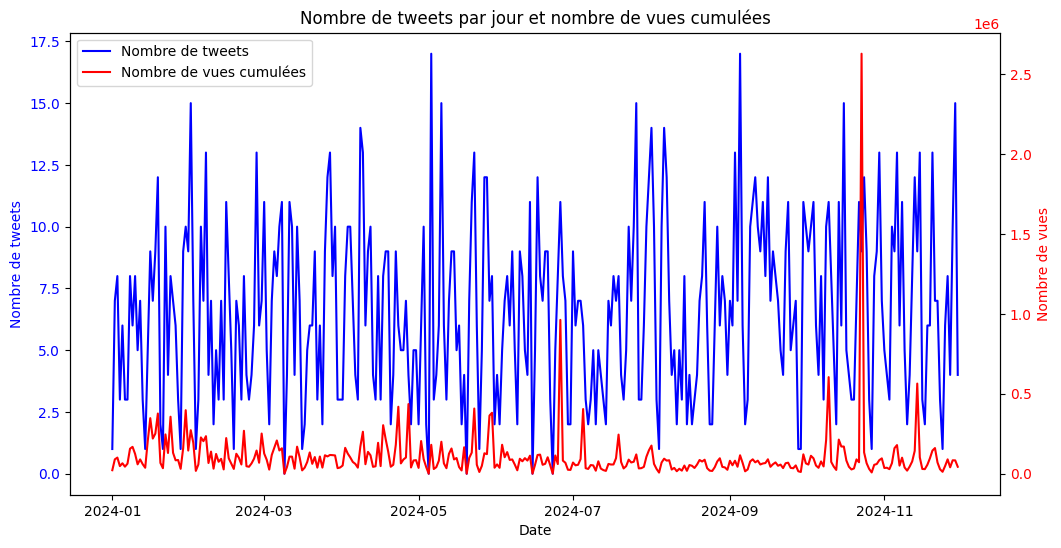

In [27]:
plt.figure(figsize=(12, 6))

# Créer le premier axe
ax1 = plt.subplot()
ax1.plot(tweets_per_day.index, tweets_per_day.values, label='Nombre de tweets', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Nombre de tweets', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Créer le second axe
ax2 = ax1.twinx()
ax2.plot(views_per_day.index, views_per_day.values, label='Nombre de vues cumulées', color='red')
ax2.set_ylabel('Nombre de vues', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Ajouter les titres et les légendes
plt.title('Nombre de tweets par jour et nombre de vues cumulées')

# Combiner les légendes des deux axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

# Afficher le graphique
plt.show()

In [28]:
df_tweet_normal[df_tweet_normal['date'].dt.date==views_per_day.idxmax().date()]

,tweet_type,time_posted,content,thread_id,comments,retweets,likes,views,extraction_date,content_cleaned,gare_detected,nb_gare_detected,content_removed_gare,content_removed_sw,content_cleand_str,is_problem,date
798,Normal,2024-10-23 13:47:35,Le train actuellement à Noisy-Champs et en dir...,c93ae658-552f-4bbd-9e15-0922af2fdee2,15,50,232,2526288,2024-12-11 20:18:48.083455,le train actuellement a noisy champs et en dir...,"Noisy-Champs,Saint-Germain-en-Laye",2,le train actuellement a et en direction de s...,"[stationne, raison, presence, obstacle, pres, ...",stationne raison presence obstacle pres voies,True,2024-10-23 13:47:35
809,Normal,2024-10-23 15:05:16,⚠️ Le trafic est perturbé de Nanterre–Préfect...,c93ae658-552f-4bbd-9e15-0922af2fdee2,4,1,10,18734,2024-12-11 20:20:10.363156,le trafic est perturbe de nanterre prefecture...,"Nanterre Préfecture,Poissy,Noisy-Champs",3,le trafic est perturbe de vers en repercuss...,"[perturbe, presence, obstacle, pres, voies]",perturbe presence obstacle pres voies,True,2024-10-23 15:05:16
812,Normal,2024-10-23 12:19:52,Le train actuellement à Vincennes et en direct...,3b763eb9-a58d-4b3a-8b37-f01db6de1cc2,2,0,0,10649,2024-12-11 20:21:22.061691,le train actuellement a vincennes et en direct...,"Vincennes,Saint-Germain-en-Laye",2,le train actuellement a et en direction de s...,"[stationne, raison, incident, technique]",stationne raison incident technique,True,2024-10-23 12:19:52
814,Normal,2024-10-23 11:57:56,Le train actuellement à Nogent-sur-Marne et en...,c81be150-4f5d-4d0e-b2a0-2979d08e6073,1,0,0,7493,2024-12-11 20:21:49.467002,le train actuellement a nogent sur marne et en...,"Nogent-sur-Marne,Cergy le Haut",2,le train actuellement a et en direction de s...,"[stationne, raison, gene, fermeture, portes]",stationne raison gene fermeture portes,True,2024-10-23 11:57:56
816,Normal,2024-10-23 11:15:31,Le train actuellement à Noisy-le-Grand–Mont d'...,2deeccb3-ccfc-4490-80c9-d9520b8067d5,2,4,3,8840,2024-12-11 20:22:14.631104,le train actuellement a noisy le grand mont d ...,"Noisy-le-Grand-Mont d'Est,Saint-Germain-en-Laye",2,le train actuellement a et en direction de s...,"[stationne, raison, gene, fermeture, portes]",stationne raison gene fermeture portes,True,2024-10-23 11:15:31
818,Normal,2024-10-23 09:29:21,Le train actuellement à La Défense et en direc...,c7a375ba-a034-4cd1-a076-4db58f272d2b,2,0,2,7017,2024-12-11 20:22:43.664125,le train actuellement a la defense et en direc...,"La Défense,Poissy",2,le train actuellement a et en direction de s...,"[stationne, raison, ajustement, intervalle]",stationne raison ajustement intervalle,True,2024-10-23 09:29:21
820,Normal,2024-10-23 05:25:32,⚠️ Le trafic est perturbé de Champigny vers B...,8c5974a6-6a06-41da-ab5d-939f7e9be222,9,2,20,28642,2024-12-11 20:23:16.834318,le trafic est perturbe de champigny vers bois...,"Champigny,Boissy-Saint-Léger,La Varenne-Chenne...",3,le trafic est perturbe de vers en raison d ...,"[perturbe, raison, incident, affectant, voie]",perturbe raison incident affectant voie,True,2024-10-23 05:25:32
827,Normal,2024-10-23 04:55:33,Le train actuellement à Champigny et en direct...,8670adee-f49b-4de9-b038-240fe7039e1a,2,1,4,13134,2024-12-11 20:24:25.956982,le train actuellement a champigny et en direct...,"Champigny,Boissy-Saint-Léger",2,le train actuellement a et en direction de s...,"[stationne, raison, incident, affectant, voies]",stationne raison incident affectant voies,True,2024-10-23 04:55:33
829,Normal,2024-10-23 03:11:43,⚠️ Le trafic est perturbé de Boissy-Saint-Lég...,f156f8e9-a407-48a0-b69f-d9e491f16a64,4,0,1,9313,2024-12-11 20:24:55.142039,le trafic est perturbe de boissy saint leger ...,"Boissy-Saint-Léger,Saint-Germain-en-Laye,Boiss...",3,le trafic est perturbe de vers en repercuss...,"[perturbe, panne]",perturbe panne,True,2024-10-23 03:11:43


### Taux engagement
On peut poursuivre l'analyse avec le taux d'engagement, soit le nombre de réactions par rapport aux nombres de vues.

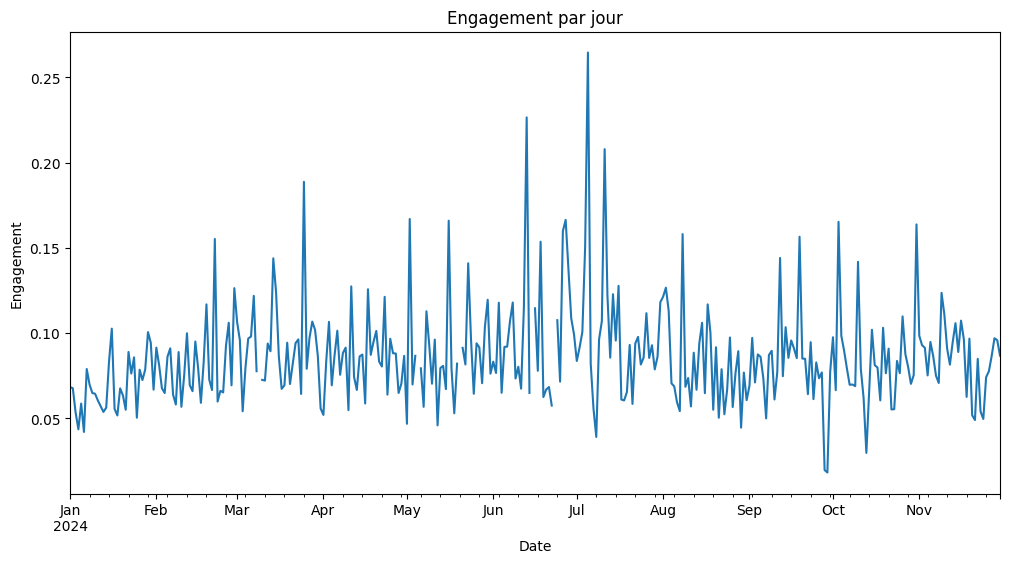

In [29]:
df_f['engagement'] = ((df_f['likes'] + df_f['retweets'] + df_f['comments']) / df_f['views'])*100



# Tracer l'engagement au fil du temps
df_f['date'] = pd.to_datetime(df_f['time_posted'])
df_tweet_normal = df_f[df_f['tweet_type']=='Normal']
engagement_per_day = df_tweet_normal.set_index('date')['engagement'].resample('D').mean()

plt.figure(figsize=(12, 6))
engagement_per_day.plot()
plt.title('Engagement par jour')
plt.xlabel('Date')
plt.ylabel('Engagement')
plt.show()

In [30]:
engagement_per_day.idxmax()

Timestamp('2024-07-05 00:00:00')

## Classification manuelle (aidé de vectorisation)
Savoir si un tweet relate un incident est une chose, trouver la nature de l'incident en est une autre. Les typologies de problèmes sont assez délimitées et observable, en prenant les cas de bases et en y associant les mots les plus courantes il est possible de former des catégories principales. Ensuite, de manière itérative en regardant les tweets d'incidents non classifiés on peut créer ou étendre une typologie...

In [31]:
labels = {
"bagage oublie": ["bagage oublie", "bagages oublies", "objet delaisse", 'bagage abandonne'],
"signal alarme": ["actionnement signal alarme", "signal alarme"],
"signalisation" : ['panne signalisation', 'incident signalisation'],
"porte" : ['panne porte', 'panne portes', 'gene fermeture portes'],
"panne electrique": ['panne electrique'],
'incident exploitation': ['difficultés exploitation', 'difficultes exploitation', 'incident exploitation', 'incident explitation'],
"incident technique": ['incident technique', 'intervention services techniques'],
"intervention personnel": ['intervention agents', 'intervention conducteur', 'forces ordre', 'intervention equipes techniques', 'intervention secours', 'intervention equipes technique', 'intervention agent'],
"voyageur": ['accident grave personne', 'acte malveillance', 'malaise voyageur', 'malaises voyageurs', 'incident voyageur', 'altercation voyageurs', 'bagarre voyageurs', 'degradation volontaire'],
"voies": ['personne voies', 'arbre voies', 'incident affectant voie', 'personnes voies', 'incident affcetant voie', 'voie occupee', 'animal voies', 'presence obstacle', 'gene circulation', 'chien voies'],
"catenaires" : ['chute catenaires', 'rupture catenaire', 'chute catenaire'],
"divers" : ['inondations', "incident informatique", "sortie garage", "mouvement social", 'chutes neige'],
"ajustement intervalle" : ['ajustement intervalle'],
"degagement fumee": ['degagement fumee'],
"regulation":['mesures regulation'],
"mesure securite": ['mesure securite', 'mesures securite', 'report voyageurs'],
"police": ['demande prefecture police', 'demande prefpolice', 'ordre prefecture police'],
"chantier": ['rallongement duree chantier', 'fin tardive chantier', 'travaux urgents'],
"affluence exceptionnelle": ['affluence exceptionnelle'],
"panne train" : ["panne de train", "panne train", "panne"],
"manoeuvre": ['manoeuvre retardee', 'changement', 'manuvre retardee'],
}

In [32]:
df_f[(df_f['is_problem']==True) & (df_f['tweet_type']=='Normal')].shape

(2157, 18)

In [33]:
df_f ['label'] = ""
for index, row in df_f.iterrows():
    #if row['is_problem']==True and row['tweet_type']=='Normal':
    if row['tweet_type']=='Normal':
        text = row['content_cleand_str']
        label_associe = []
        for label in labels:
            for word in labels[label]:
                if word in text:
                    text = text.replace(word, '')
                    label_associe.append(label)
                    
        
        df_f.at[index, 'label'] = ",".join(label_associe)
df_f['len_label'] = df_f['label'].apply(lambda x: 0 if x=="" else len(x.split(',')))

In [34]:
df_f[(df_f['tweet_type']=="Normal") & (df_f['is_problem']==True)].groupby('len_label').size()

len_label
0      18
1    2127
2      12
dtype: int64

In [35]:
df_f[(df_f['tweet_type']=="Normal") & (df_f['len_label']==0)& (df_f['is_problem']==True)][['content', 'content_cleand_str']].values

array([["❌   les voyageurs du RER A, le trafic est interrompu entre Auber et Vincennes et reprendra vers 00:30. . le trafic est très perturbé sur l'ensemble de la ligne. #RERA",
        'voyageurs rer interrompu reprendra tres perturbe ensemble ligne'],
       ['⚠️  Un train stationne à Chatelet les Halles en direction de Cergy/Poissy  #RERA',
        'stationne'],
       ['⚠️ Le trafic est perturbé à Nanterre – Préfecture en direction de Marne-la-Vallée – Chessy. Nous vous présentons nos excuses et nos agents sont mobilisés pour un retour à la normale au plus vite  #RERA',
        'perturbe presentons excuses agents mobilises retour normale plus vite'],
       ['Trafic perturbé RER A', 'perturbe rer'],
       ['Citation du tweet du 2024-04-23 14:55:29', 'citation tweet'],
       ['Citation du tweet du 2024-04-23 13:56:56', 'citation tweet'],
       ['Citation du tweet du 2024-04-23 10:48:26', 'citation tweet'],
       ['Citation du tweet du 2024-04-17 04:05:39', 'citation tweet'],
   

In [59]:
df_f[(df_f['label']=='intervention personnel') & (df_f['tweet_type']=='Normal')]['content'].values

array(["⚠️ Le stationnement est prolongé à Vincennes en direction de Marne-la-Vallée – Chessy, en raison d'un incident nécessitant l'intervention du conducteur.  #RERA",
       "Le train actuellement à Val de Fontenay et en direction de Torcy stationne en raison de l'intervention des agents.  #RERA",
       "Le train actuellement à La Défense et en direction de Boissy-Saint-Léger stationne en raison d'un incident nécessitant l'intervention de nos agents.  #RERA",
       "Le train actuellement à Charles de Gaulle–Étoile et en direction de Poissy stationne en raison d'un incident nécessitant l'intervention de nos agents.  #RERA",
       "Le train actuellement à Rueil-Malmaison et en direction de Saint-Germain-en-Laye stationne en raison de l'intervention des agents.  #RERA",
       "Le train actuellement à Vincennes et en direction de Saint-Germain-en-Laye stationne en raison de l'intervention des agents.  #RERA",
       "Le train actuellement à La Varenne–Chennevières et en direction de

## Trouver la gare source du problème
A present on sait d'un tweet : s'il parle d'un incident et la typologie de l'incident mentionné ; l'idéal serait de savoir la localisation de l'origine du problème. Il est évident que les gares les plus empruntées (Chatelet, Auber...) concentreront une grande partie des occurrences.

En début d'analyse, les gares détectées dans le tweet ont été récupérées (en maintenant l'ordre d'apparition), et ce qui est bien à ce moment est que la syntaxe des tweets est récurrentes. Très souvent il y a les mêmes formulations de phrases disant qu'un train est à l'arrêt à une X gare à cause d'un problème Y. Cette récurrence de formulation est assez forte pour pouvoir établir des REGEX pour capturer le nom de la gare en question où le problème est survenu.

Et encore une fois, de facon itérative en prenant les tweets d'incidents sur lesquels la gare d'origine de l'incident n'a pas été capturé, on peut ajouter des REGEX.

In [36]:
df_with_problem_and_label = df_f[(df_f['is_problem']==True) & (df_f['len_label']>0)]

In [37]:
df_with_problem_and_label.groupby(['label', 'nb_gare_detected']).size()

label                     nb_gare_detected
affluence exceptionnelle  3                    1
                          4                    1
                          6                    1
ajustement intervalle     2                    6
                          3                    2
                                              ..
voyageur                  4                   19
                          5                    5
voyageur,panne train      2                    1
                          3                    1
voyageur,voyageur         2                    1
Length: 98, dtype: int64

In [38]:
gare_source_regex = [
    "stationne à (.*)en raison", 
    "actuellement à (.*) en raison", 
    "ne marquent pas l arret en gare de (.*)",
    "stationne a .* en raison",
    "stationne au .* en raison",
    "stationnement .*? a .* en raison",
    "actuellement .* en raison",
    "en raison .*? a .{6,}$",
    "en raison .*? gare .*",
    "en raison .*? au .*",
    "est perturbe de (.*)",
    "est perturbe a .* en raison",
    "intervention .*? a .*",
    "en repercussion .*? a .*",
    "en repercussion .*? en gare de .*",
    "stationne .*? a .*",
    "gare .*? en repercussion .*? sur le quai",
    "cela fait suite .*? a .*",
    "panne a .*",
    "sur ordre .+? police, la gare de .*"
    ]

df_with_problem_and_label['gare_source'] = ""
for index, row in df_with_problem_and_label.iterrows():
    if row['tweet_type']=='Normal' and row['is_problem']==True:
        for regex in gare_source_regex:
            match = re.search(regex, row['content_cleaned'])
            if match:
                
                current_text = match.group(0)
                cursor_deb = 0
                cursor_end = 1

                gare_detected = []

                while cursor_end <= len(current_text):

                    gare, gare_key = find_gare(current_text[cursor_deb:cursor_end])

                    if gare is None:
                        cursor_end += 1
                    else:
                        gare, cursor_end = find_max_len_gare_from_key(gare_key, gare, current_text, cursor_deb, cursor_end)
                        gare_detected.append(gare_key)
                        cursor_deb = cursor_end
                        cursor_end = cursor_deb + 1 

                print(current_text)
                df_with_problem_and_label.loc[index, 'gare_source'] = gare_detected[0]
                break
            elif row['nb_gare_detected']==1:
                df_with_problem_and_label.loc[index, 'gare_source'] = row['gare_detected']
                break


C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3891442696.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_problem_and_label['gare_source'] = ""


stationnement est prolonge a vincennes en direction de marne la vallee chessy en raison
en raison d un malaise voyageur a chatelet les halles rera
en raison d un train en panne a poissy rera
stationne a noisy le grand mont d est en direction de poissy en raison
en raison d un incident d exploitation a poissy rera
stationnement est prolonge a val de fontenay en direction de marne la vallee chessy en raison
actuellement a nation et en direction de torcy stationne en raison
actuellement a chatelet les halles et en direction de boissy saint leger stationne en raison
actuellement a val de fontenay et en direction de torcy stationne en raison
actuellement a la defense et en direction de la varenne chennevieres stationne en raison
actuellement a la defense et en direction de boissy saint leger stationne en raison
actuellement a charles de gaulle etoile et en direction de poissy stationne en raison
actuellement houilles carrieres sur seine et en direction de cergy le haut poissy stationne en r

In [39]:
df_with_problem_and_label[(df_with_problem_and_label['tweet_type']=='Normal') & (df_with_problem_and_label['len_label']>0)].groupby(['gare_source']).size()

gare_source
                                 27
Achères Ville                    68
Auber                           121
Boissy-Saint-Léger               62
Bry-sur-Marne                    31
Bussy-Saint-Georges              40
Cergy le Haut                    73
Champigny                        25
Charles de Gaulle-Etoile         86
Chatou-Croissy                    9
Châtelet les Halles             137
Conflans Fin d'Oise              11
Fontenay-sous-Bois               60
Gare de Lyon                     90
Houilles-Carrières-sur-Seine     34
Joinville-le-Pont                21
La Défense                      122
La Varenne-Chennevières          54
Le Vésinet-Centre                 2
Le Vésinet-Le Pecq               15
Lognes                           18
Maisons-Laffitte                 37
Marne-la-Vallée-Chessy           72
Nanterre Préfecture             185
Nanterre Université              18
Nanterre Ville                   24
Nation                           67
Neuilly-Plaisanc

In [40]:
df_with_problem_and_label[(df_with_problem_and_label['gare_source']=="")].content_cleaned.values

array([' le train stationne a gare de lyon en direction de marne la vallee chessy pour un bagage abandonne rer',
       'le train actuellement entre la defense et nanterre prefecture et en direction de saint germain en laye stationne d un incident technique sur un train rera',
       'le train actuellement a noisy le grand mont d est et en direction de marne la vallee chessy stationne d un incident necessitant l intervention du conducteur rera',
       ' le stationnement est prolonge en sortie de chatelet les halles en direction de cergy le haut en raison d un incident necessitant l intervention du conducteur rera',
       ' le trafic est tres perturbe sur l ensemble de la ligne en repercussion d une panne de signalisation rera',
       ' l arret n est pas desservi a lognes en direction de poissy cergy le haut et saint germain en laye en raison de mesures de securite rera',
       ' les trains stationnent entre bry sur marne et neuilly plaisance en raison d une panne electrique rera',


## Première visualisation
L'idée maintenant est de faire une première visualisation quant aux nombres d'incidens notifiés.

In [41]:
incident_notifies = df_with_problem_and_label[(df_with_problem_and_label['tweet_type']=='Normal') & (df_with_problem_and_label['is_problem']==True) &(df_with_problem_and_label['len_label']>0)]
incident_notifies['date'] = pd.to_datetime(incident_notifies['time_posted'])

incident_par_mois = incident_notifies.groupby(incident_notifies['date'].dt.to_period('M')).size()
incident_par_jour = incident_notifies.groupby(incident_notifies['date'].dt.to_period('D')).size()

tweets_per_day_label = incident_notifies.groupby([incident_notifies['date'].dt.to_period('D'), 'label']).size().unstack(fill_value=0)
tweets_per_day_label.index = tweets_per_day_label.index.to_timestamp()

total_tweets_per_label = tweets_per_day_label.sum()
# Sélectionner les labels les plus nombreux (par exemple, les 5 premiers)
top_labels = total_tweets_per_label.nlargest(3).index


incident_par_mois.index = incident_par_mois.index.to_timestamp()
incident_par_jour.index = incident_par_jour.index.to_timestamp()

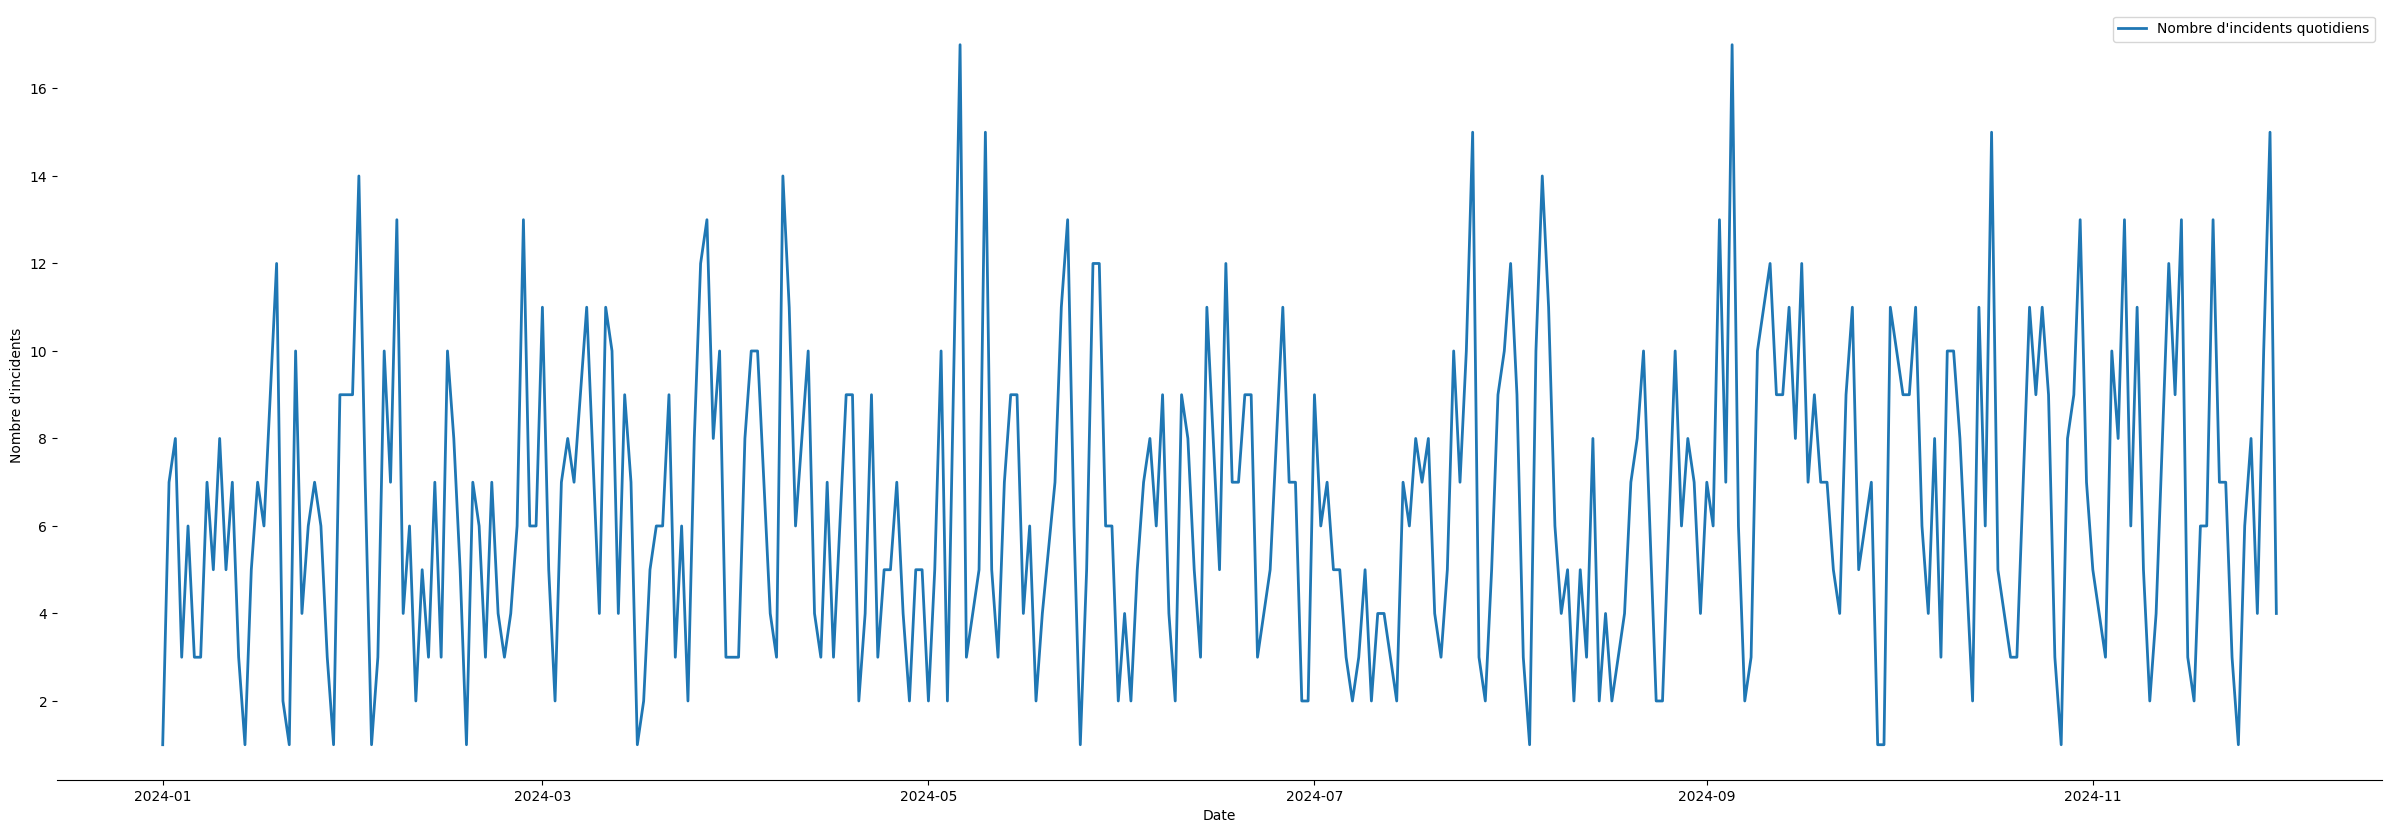

In [42]:
fig, ax = plt.subplots(
    figsize=(30, 10)
)

ax.plot(incident_par_jour.index, incident_par_jour.values, label="Nombre d'incidents quotidiens", linewidth=2)


ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
#ax.spines["bottom"].set_bounds(min(incident_par_jour.index), max(incident_par_jour.index))

ax.set_xlabel("Date")
ax.set_ylabel("Nombre d'incidents")
plt.legend()
plt.show()

## Temps de résolution
Maitenant en possession des tweets d'incidents, l'objectif va être de calculer de le temps de réponse à incidents, soit le temps entre le moment où l'incident est déclaré et le moment où il est résolu.

Malheuresement, on ne peut pas prende tous les thread récoltés, car certains n'ont pas de conclusion sur l'incident mentionné. Ici, comme pour les cas précédents en établissant une liste de phrase employées pour conclure un incident, on va chercher les thread dont on peut calculer la temps de résolution.

In [43]:
## On s'en foutait de cette partie

df_f['time_posted'] = pd.to_datetime(df_f['time_posted'])

tweets_incidents = df_f[(df_f['is_problem']==True) & (df_f['tweet_type']=='Normal')]
fin_incident = r'le trafic est regulier|repartie|incident termine|retour a un trafic normal|train repart|retabli|reprend|repartir|trains repartent|retour a un trafic regulier|est termine|le trafic reprend normalement|✅|marquent a nouveau l arret|le trafic est normal|rouverte|repartit'

tweets_incidents_with_end = df_f[(df_f['is_problem']==True) & (df_f['tweet_type']=='Normal')]

for index, row in tweets_incidents.iterrows():
    thread_id = row['thread_id']

    reponses_thread = df_f[(df_f['thread_id']==thread_id) & (df_f['tweet_type']=='Réponse')]['content_cleaned']
    
    if reponses_thread.str.contains(fin_incident, case=False, na=False).any():
        pass
    else:
        print(reponses_thread.values)
        tweets_incidents_with_end.drop(index, inplace=True)

[' fin de stationnement a chatelet les halles en direction de cergy le haut malaise voyageur rera']
['fin de stationnement entre auber et noisy le grand mont d est joinville le pont bagage oublie sur un quai a nation rera']
[' la gare de charles de gaulle etoile est de nouveau ouverte au public rera']
[' fin du stationnement rera']
['les trains ne marqueront pas l arret les correspondances ne seront pas assurees la reouverture interviendra sur autorisation de la prefpolice rera']
[' fin d incident le trafic est a nouveau regulier sur l ensemble du rer_a']
[' le trafic est perturbe sur l ensemble de la ligne en raison d un incident affectant les voies a val de fontenay rera'
 ' le trafic est perturbe entre saint germain en laye et marne la vallee chessy en raison d un incident affectant les voies a val de fontenay rera']
[' fin du stationnement la rame repart rera']
[' fin de stationnement a chatelet les halles en direction de cergy le haut rera']
[' fin de stationnement a chatelet les 

C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_incidents_with_end.drop(index, inplace=True)
C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_incidents_with_end.drop(index, inplace=True)
C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

[' fin de stationnement au parc de saint maur rera']
[' fin de stationnement a auber en direction de saint germain en laye rera']
[' le train est reparti de bussy saint georges rera']
[' le trafic est perturbe de nanterre prefecture vers boissy saint leger marne la vallee chessy en raison de mesures de securite a chatelet les halles rera'
 ' le trafic est tres perturbe de nanterre prefecture vers boissy saint leger marne la vallee chessy en raison de mesures de securite a chatelet les halles rera'
 ' le trafic est tres perturbe de cergy le haut poissy vers boissy saint leger marne la vallee chessy en raison de mesures de securite a chatelet les halles rera'
 ' le trafic est tres perturbe de saint germain en laye cergy le haut poissy vers boissy saint leger marne la vallee chessy en raison de mesures de securite a chatelet les halles rera'
 ' le trafic est perturbe de saint germain en laye cergy le haut poissy vers boissy saint leger marne la vallee chessy en repercussion d une panne de

C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_incidents_with_end.drop(index, inplace=True)
C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_incidents_with_end.drop(index, inplace=True)
C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

[' le trafic est perturbe sur l ensemble de la ligne en raison d un incident technique a la defense rera']
[' le trafic est tres perturbe sur l ensemble la ligne en raison d un incident technique a la defense rera']
['fin de stationnement les trains reprennent leur marche personne sur les voies rera']
[' le trafic est perturbe de vincennes vers saint germain en laye et cergy le haut poissy en raison d une panne d un train a chatelet les halles rera'
 ' le trafic est perturbe de vincennes vers saint germain en laye et cergy le haut poissy en raison d un incident voyageur a chatelet les halles rera'
 ' le trafic est perturbe sur l ensemble de la ligne en raison d un malaise voyageur a auber et d un incident voyageur a chatelet les halles rera'
 ' le trafic est perturbe entre vincennes et saint germain en laye et cergy le haut poissy en raison d un incident voyageur a chatelet les halles rera']
[' le trafic est perturbe sur l ensemble de la ligne en raison d un train en panne a lognes et 

C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_incidents_with_end.drop(index, inplace=True)
C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_incidents_with_end.drop(index, inplace=True)
C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

[' fin de stationnement a le parc de saint maur en direction de boissy saint leger rera']
[' fin de stationnement a maisons laffitte en direction de boissy saint leger rera']
[' fin de stationnement a val de fontenay le train est reparti en direction de marne la vallee chessy rera']
[' fin d incident le trafic est a nouveau regulier sur l ensemble du rera']
[' fin d incident le trafic est a nouveau regulier sur l ensemble du rera']
[' fin d incident le trafic est a nouveau regulier sur l ensemble du rera']
[' le trafic est perturbe de nanterre p vers boissy saint leger et mlv chessy en repercussion d un bagage oublie dans un train a gare de lyon rera'
 ' le trafic est perturbe sur l ensemble de la ligne en repercussion d un bagage oublie dans un train a gare de lyon rera'
 ' le trafic est perturbe de vincennes vers boissy saint leger et marne la vallee chessy en repercussion d un bagage oublie dans un train a gare de lyon rera'
 ' fin d incident le trafic est a nouveau regulier de vinc

C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_incidents_with_end.drop(index, inplace=True)
C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_incidents_with_end.drop(index, inplace=True)
C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

[' le trafic est a nouveau normal de cergy le haut vers boissy st leger sur le rera']
[' fin d incident rera']
[' les trains circulent a vitesse reduite entre saint germain en laye et rueil malmaison en raison d un incident affectant les voies a saint germain en laye rera']
['fin de stationnement a torcy voie occupee par un autre train rera']
['fin de stationnement a torcy signal d alarme abusif rera']
[' fin de stationnement a bry sur marne en direction de saint germain en laye rera']
[' le trafic est interrompu entre nanterre universite et chatou croissy les services de secours interviennent aupres dune victime dun accident grave a rueil malmaison nous vous tiendrons informes de levolution de la situation reprise estimee a rera']
[' un train stationne a bry sur marne en direction de marne la vallee chessy en raison d une panne electrique rera'
 ' fin d incident de stationnement a bry sur marne rera']
[' fin de stationnement a nogent sur marne en direction de boissy saint leger rera']

C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_incidents_with_end.drop(index, inplace=True)
C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_incidents_with_end.drop(index, inplace=True)
C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

[' le trafic est perturbe de marne la vallee chessy vers cergy le haut et poissy en raison d un malaise voyageur a noisy champs rera'
 ' le trafic est perturbe de marne la vallee chessy vers cergy le haut en repercussion d un malaise voyageur a noisy champs rera']
[' fin de stationnement a noisy le grand mont d est en direction de marne la vallee chessy rera']
[' fin de stationnement a joinville le pont en direction de boissy saint leger rera']
[' fin de stationnement a lognes en direction de saint germain en laye rera']
[' le trafic est perturbe de marne la vallee chessy vers cergy le haut et poissy en raison d une panne de portes de train a torcy rera'
 ' le trafic est perturbe de marne la vallee chessy vers poissy en raison d une panne de portes de train a torcy rera'
 ' le trafic est perturbe de nanterre prefecture vers poissy en raison d une panne de portes de train a torcy rera'
 ' fin d incident sur le rera']
[' fin d incident sur le rera']
[' les prochains passages a rueil malm

C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_incidents_with_end.drop(index, inplace=True)
C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_incidents_with_end.drop(index, inplace=True)
C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

[' le trafic est tres perturbe entre boissy saint leger et cergy le haut poissy en raison d un incident technique et de la chute d un arbre sur les voies a sucy bonneuil rera']
[' le trafic est perturbe entre boissy saint leger et cergy le haut poissy en raison d un incident technique et de la chute d un arbre sur les voies a sucy bonneuil rera']
[' le trafic est perturbe entre boissy saint leger et joinville le pont en raison de la chute d un arbre sur les voies a sucy bonneuil rera'
 ' le trafic est perturbe de boissy saint leger vers cergy le haut poissy en raison de la chute d un arbre sur les voies a sucy bonneuil rera'
 ' le trafic est tres perturbe entre boissy saint leger et cergy le haut poissy en raison de la chute d un arbre sur les voies a sucy bonneuil rera'
 ' le trafic est perturbe de boissy saint leger vers cergy le haut poissy en raison de la chute d un arbre sur les voies a sucy bonneuil rera']
[' la gare de la varenne chennevieres est fermee inondations rera']
['fin 

C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_incidents_with_end.drop(index, inplace=True)
C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_incidents_with_end.drop(index, inplace=True)
C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

[' le trafic est perturbe de charles de gaulle etoile vers marne la vallee chessy et boissy saint leger en raison de l actionnement d un signal d alarme a chatelet les halles rera']
['fin de stationnement personnes sur les voies rera']
[' fin de stationnement a joinville le pont en direction de poissy rera']
[' fin de stationnement a auber rera']
[' fin de stationnement a bry sur marne rera']
[' fin de stationnement la rame repart rera']
[' bagage oublie dans un train a marne la vallee chessy fin d incident rera']
[' fin de perturbation rera']
[' fin d incident sur le rer a rera']
[' le train est reparti de bussy st georges a la suite de l intervention des equipes techniques rera']
[' le trafic est perturbe sur l ensemble de la ligne en repercussion d un rallongement de duree de chantier a chatelet les halles rera']
[' le trafic est perturbe de marne la vallee chessy vers rueil malmaison en raison d un train en panne a marne la vallee chessy rera'
 ' fin d incident sur le rera']
['fin 

C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_incidents_with_end.drop(index, inplace=True)
C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_incidents_with_end.drop(index, inplace=True)
C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

[' le trafic est perturbe de cergy le haut vers boissy saint leger en raison d un train en panne a neuville universite rera'
 ' le trafic est perturbe entre cergy le haut poissy et boissy saint leger en raison d un train en panne a neuville universite rera'
 ' le trafic est tres perturbe de la defense vers cergy le haut poissy en raison d un train en panne a neuville universite rera']
[' fin d incident a bussy saint georges en direction de cergy le haut malaise voyageur rera']
[' fin d incident malaise voyageur a nanterre prefecture rera']
[' fin d incident la rame repart rera']
[' fin de stationnement a rueil malmaison en direction de saint germain en laye rera']
[' fin de stationnement a neuilly plaisance en direction de marne la vallee chessy rera']
['fin de stationnement a marne la vallee chessy incident voyageur rera']
[' fin de stationnement a neuilly plaisance en direction de cergy le haut rera']
[' fin du stationnement le trafic reste perturbe sur le rera']
[' le trafic est per

C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_incidents_with_end.drop(index, inplace=True)
C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_incidents_with_end.drop(index, inplace=True)
C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

['fin de stationnement a torcy difficultes d exploitation rera']
['sur les branches cergy le haut et poissy prevoir train sur toute la journee pas de changement de train necessaire a nanterre prefecture '
 ' le blog du rer a']
[' fin de stationnement a noisiel en direction de marne la vallee chessy rera']
[' fin de stationnement a torcy en direction de cergy le haut rera']
[' la gare de la defense est fermee au public ceci jusqu a nouvel ordre les correspondances dans la gare sont impossibles les trains passent sans marquer l arret cela fait suite a un degagement de fumee rera'
 ' fin d incident en gare de la defense qui est de nouveau ouverte au public rera']
[' fin d incident le trafic est a nouveau regulier sur l ensemble du rer_a'
 ' le trafic est perturbe de vincennes vers rueil malmaison cergy poissy en repercussion d un malaise voyageur a charles de gaulle etoile rera']
[' le trafic est perturbe de mlv chessy vers nanterre prefecture sur le rera en raison de difficultes d exploi

C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_incidents_with_end.drop(index, inplace=True)
C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_incidents_with_end.drop(index, inplace=True)
C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

[' le trafic est interrompu entre torcy et marne la vallee chessy et est perturbe sur le reste de la ligne en raison d un degagement de fumee a bussy saint georges reprise estimee a rera'
 ' le trafic est interrompu entre torcy et val d europe et est perturbe sur le reste de la ligne en raison d un degagement de fumee a bussy saint georges reprise estimee a rera'
 ' le trafic est interrompu entre torcy et marne la vallee chessy et est perturbe sur le reste de la ligne en raison d un degagement de fumee a bussy saint georges reprise estimee a rera']
[' le trafic est perturbe de nanterre ville vers st germain en raison d un train en panne a nanterre ville sur le rera'
 ' le trafic est perturbe entre saint germain et la defense en raison d un train en panne a nanterre ville sur le rera']
[' le train est reparti de auber en direction de boissy saint leger gene a la fermeture des portes rera']
[' le trafic est perturbe de nanterre prefecture vers marne la vallee chessy boissy saint leger ra

C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_incidents_with_end.drop(index, inplace=True)
C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_incidents_with_end.drop(index, inplace=True)
C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

[' fin de stationnement a nanterre prefecture en direction de cergy le haut rera']
['image']
[' le trafic est perturbe sur l ensemble de la ligne en repercussion d un incident affectant la voie a rueil malmaison rera']
[' le trafic est tres perturbe entre saint germain en laye et la defense en raison d un incident affectant la voie a rueil malmaison rera'
 ' le trafic est perturbe entre saint germain en laye et marne la vallee chessy en raison d un incident affectant la voie a rueil malmaison rera']
[' fin d incident le trafic est a nouveau regulier sur l ensemble du rer_a']
[' fin de stationnement a val de fontenay en direction de marne la vallee chessy rera']
[' fin de stationnement a chatelet les halles en direction de saint germain en laye rera']
[' fin de stationnement a chatelet les halles en direction de torcy rera']
[' fin de stationnement a charles de gaulle etoile en direction de marne la vallee chessy rera']
[' fin de stationnement entre charles de gaulle etoile et vincennes

C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_incidents_with_end.drop(index, inplace=True)
C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_incidents_with_end.drop(index, inplace=True)
C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

[' fin de stationnement a chatelet les halles en direction de marne la vallee chessy rera']
[' fin d incident a nanterre prefecture rera']
[' fin d incident le train est reparti rera']
[' fin de stationnement a nanterre ville en direction de marne la vallee chessy rera']
[' le trafic est a nouveau normal sur l ensemble de la ligne rera']
[' fin de stationnement a neuilly plaisance en direction de marne la vallee chessy rera']
[' fin de stationnement a neuilly plaisance en direction de marne la vallee chessy rera']
[' fin de stationnement a bussy saint georges en direction de marne la vallee chessy en raison de l intervention des forces de l ordre rera']
[' fin des repercussions liees au bagage oublie a mlv chessy rera']
[' fin de stationnement a champigny en direction de poissy rera']
[' fin de stationnement a nation rera']


C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_incidents_with_end.drop(index, inplace=True)
C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_incidents_with_end.drop(index, inplace=True)
C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

[' fin d incident le trafic est a nouveau regulier sur l ensemble du rer_a']
[' fin des perturbations sur le rera']
[' le trafic est perturbe de vincennes vers cergy le haut poissy et saint germain en laye en raison d un malaise voyageur a vincennes rera'
 ' le trafic est perturbe sur l ensemble de la ligne en repercussion d un malaise voyageur a vincennes et d un incident voyageur a nogent sur marne rera']
[' le trafic est perturbe de saint germain en laye vers marne la vallee chessy en raison d un acte de malveillance a charles de gaulle etoile rera'
 ' le trafic est perturbe de saint germain en laye vers marne la vallee chessy en repercussion d un acte de malveillance a charles de gaulle etoile rera']
['fin de stationnement a la defense incident voyageur rera']
[' fin de stationnement a chatou croissy en direction de saint germain en laye rera']
[' l arret est de nouveau desservi a gare de lyon sur le rera en repercussion d un bagage oublie ']
[' le trafic est desormais regulier ent

C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_incidents_with_end.drop(index, inplace=True)
C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_incidents_with_end.drop(index, inplace=True)
C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

[' le trafic est perturbe de saint germain en laye vers marne la vallee chessy en raison d un malaise voyageur a nanterre ville rera'
 ' la gare de nanterre ville n est pas desservie en direction de marne la vallee chessy malaise voyageur rera'
 ' le trafic est perturbe sur l ensemble de la ligne en raison de deux malaises voyageurs a nanterre ville et a chatelet les halles rera']
[' le trafic est a nouveau normal de nanterre prefecture vers boissy saint leger sur le rera en repercussion d un malaise voyageur a vincennes ']
[' un train stationne a vincennes en direction de poissy en raison d un malaise voyageur rera'
 ' fin de stationnement pour zumo vincennes victime prise en charge par les rera'
 ' le trafic est perturbe de vincennes vers saint germain en laye poissy et cergy le haut en raison d un malaise voyageur a vincennes rera en attente de l intervention de la brigade de sapeurs pompiers de paris rera'
 ' le trafic est perturbe sur l ensemble de la ligne en raison d un malaise 

C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_incidents_with_end.drop(index, inplace=True)
C:\Users\gabriel\AppData\Local\Temp\ipykernel_5884\3464432746.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_incidents_with_end.drop(index, inplace=True)


In [44]:
print(tweets_incidents.shape)
print(tweets_incidents_with_end.shape)

(2157, 20)
(1929, 20)


Connaissant les thread possédant des tweets sur les incidents, ainsi qu'une réponse permettant de savoir quand l'incident est terminé, il ne reste plus quà regarder pour chacun de ces thread la date à laquelle l'incident est mentionné ainsi que la date de publication de la réponse concluant l'incident. De cette manière, on aura le temps de réponse à incident.

In [45]:
pb_resolve = {
    'id': [],
    'begin_date': [],
    'end_date': [],
    'duration': [],
    'label':[]
}
for id in tweets_incidents_with_end['thread_id'].unique():


    
    df_id = df_f[df_f['thread_id']==id]

    begin_date = df_id[df_id['tweet_type']=='Normal']['date'].values[0]

    try:
        #end_date = df_id[df_id['tweet_type']=='Réponse'].sort_values('date', ascending=False).iloc[0]['date']
        end_date = df_id[(df_id['tweet_type'] == 'Réponse') & (df_id['content'].str.contains(fin_incident, case=False, na=False))].sort_values('date', ascending=False).iloc[0]['date']

    except Exception:
        continue

    pb_resolve['id'].append(id)
    pb_resolve['begin_date'].append(begin_date)
    pb_resolve['end_date'].append(end_date)
    pb_resolve['duration'].append(end_date - begin_date)
    pb_resolve['label'].append(df_id[df_id['tweet_type']=='Normal']['label'].values[0])


In [46]:
pb_resolve_df = pd.DataFrame.from_dict(pb_resolve)
pb_resolve_df['duration'].describe()

count                         1911
mean     0 days 01:47:25.847723704
std      2 days 02:32:27.777603189
min              -1 days +21:40:29
25%                0 days 00:02:49
50%                0 days 00:07:13
75%                0 days 00:51:59
max               92 days 01:29:17
Name: duration, dtype: object

In [47]:
pb_resolve_df.iloc[pb_resolve_df['duration'].idxmin()]
pb_resolve_df.drop(pb_resolve_df['duration'].idxmin(), inplace=True)
pb_resolve_df.reset_index(drop=True, inplace=True)

In [48]:
pb_resolve_df.iloc[pb_resolve_df['duration'].idxmax()]
pb_resolve_df.drop(pb_resolve_df['duration'].idxmax(), inplace=True)
pb_resolve_df.reset_index(drop=True, inplace=True)

In [49]:
pb_resolve_df['duration'].describe()

count                         1909
mean     0 days 00:38:10.324253535
std      0 days 01:07:26.421037526
min                0 days 00:00:22
25%                0 days 00:02:49
50%                0 days 00:07:13
75%                0 days 00:51:53
max                0 days 17:33:38
Name: duration, dtype: object

<Axes: >

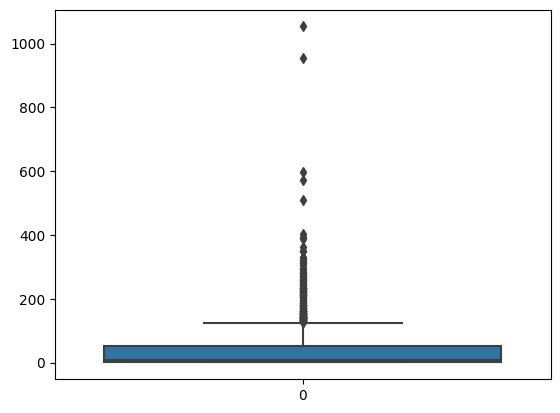

In [50]:
sns.boxplot(pb_resolve_df['duration'].dt.total_seconds() / 60)

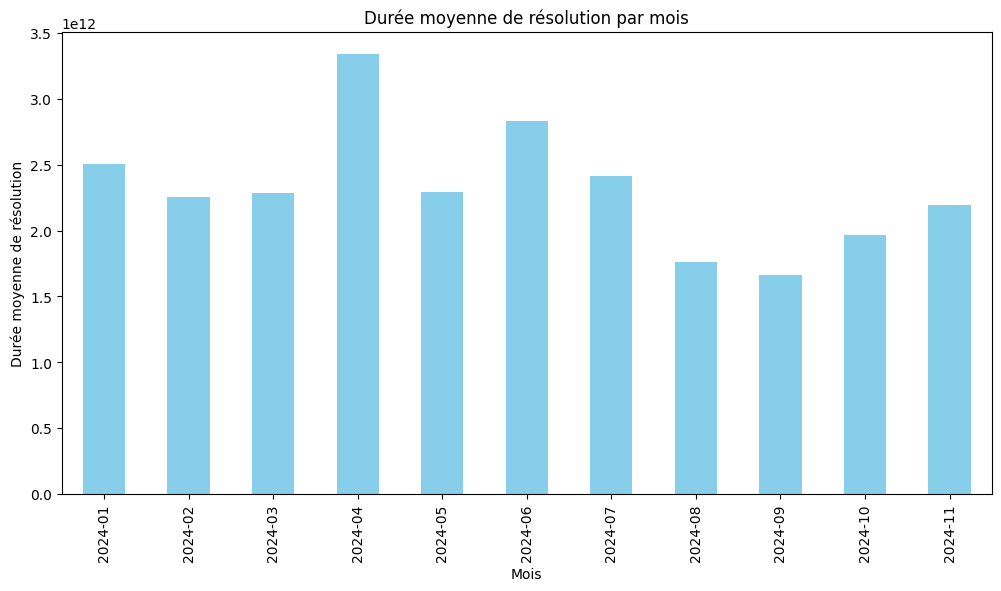

In [51]:
# Ajouter une colonne pour le mois
pb_resolve_df['month'] = pb_resolve_df['begin_date'].dt.to_period('M')

# Calculer la durée moyenne par mois
average_duration_per_month = pb_resolve_df.groupby('month')['duration'].mean()

# Tracer les données
plt.figure(figsize=(12, 6))
average_duration_per_month.plot(kind='bar', color='skyblue')

# Ajouter des titres et des étiquettes
plt.title('Durée moyenne de résolution par mois')
plt.xlabel('Mois')
plt.ylabel('Durée moyenne de résolution')

# Afficher le graphique
plt.show()

## Stats générales

### Top incidents (occurrence et période)

In [52]:
print(incident_notifies.date.dt.time.max())
print(incident_notifies.date.dt.time.min())

23:59:30
00:01:12


In [53]:
incident_notifies.shape


(2139, 21)

In [54]:
incidents_peak_hour = incident_notifies[incident_notifies['date'].dt.hour.isin([7, 8, 9, 16, 17, 18, 19])]

In [55]:
incident_notifies.label

def count_incidents(df, column_name):
    count_incident = Counter()
    for label in df[column_name]:
        incidents = label.split(',')
        count_incident.update(incidents)
    return count_incident
counter_incidents = count_incidents(incident_notifies, 'label')
counter_incidents.most_common(6)

[('intervention personnel', 489),
 ('signal alarme', 330),
 ('voyageur', 251),
 ('panne train', 169),
 ('bagage oublie', 157),
 ('incident exploitation', 154)]

In [179]:
incident_notifies.groupby(incident_notifies['date'].dt.to_period('M')).size().sort_values(ascending=False)

date
2024-09    233
2024-10    230
2024-11    208
2024-03    202
2024-05    193
2024-04    186
2024-08    184
2024-07    179
2024-06    177
2024-02    174
2024-01    173
Freq: M, dtype: int64

In [180]:
incident_notifies.groupby(incident_notifies['date'].dt.to_period('M')).size().sort_values(ascending=False)[0]/incident_notifies.groupby(incident_notifies['date'].dt.to_period('M')).size().sum()


0.10892940626460963

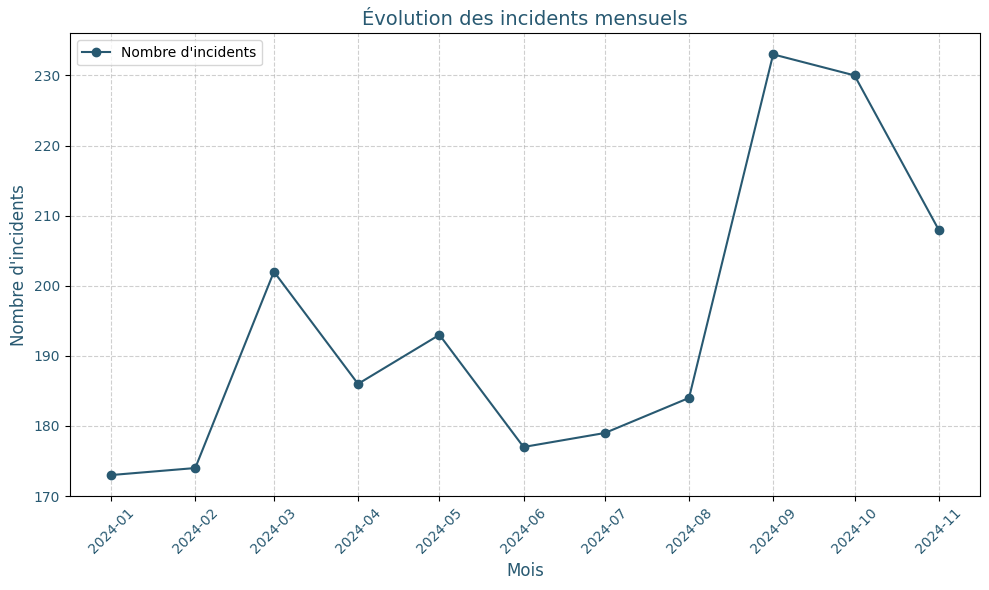

In [80]:
import matplotlib.pyplot as plt

# Grouper les données par mois et compter les incidents
monthly_counts = incident_notifies.groupby(incident_notifies['date'].dt.to_period('M')).size()

# Convertir l'index en datetime pour un traçage approprié
monthly_counts.index = monthly_counts.index.to_timestamp()

# Tracer la ligne
plt.figure(figsize=(10, 6))
plt.plot(monthly_counts.index, monthly_counts.values, marker='o', color='#285971', label="Nombre d'incidents")

# Ajouter des étiquettes et un titre
plt.title("Évolution des incidents mensuels", fontsize=14, color='#285971')
plt.xlabel("Mois", fontsize=12, color='#285971')
plt.ylabel("Nombre d'incidents", fontsize=12, color='#285971')

# Personnaliser les ticks
plt.xticks(fontsize=10, color='#285971', rotation=45)
plt.yticks(fontsize=10, color='#285971')

# Ajouter une grille légère
plt.grid(visible=True, linestyle='--', alpha=0.6)

# Afficher une légende
plt.legend()

# Afficher le graphique
plt.tight_layout()
plt.show()


In [ ]:
incidents_peak_hour.shape

(754, 20)

### Gares

In [181]:
incident_notifies.groupby('gare_source').size().sort_values(ascending=False)

gare_source
Nanterre Préfecture             185
Châtelet les Halles             137
La Défense                      122
Auber                           121
Torcy                           113
Gare de Lyon                     90
Charles de Gaulle-Etoile         86
Vincennes                        85
Rueil-Malmaison                  75
Cergy le Haut                    73
Marne-la-Vallée-Chessy           72
Achères Ville                    68
Nation                           67
Boissy-Saint-Léger               62
Poissy                           60
Fontenay-sous-Bois               60
La Varenne-Chennevières          54
Val d'Europe                     44
Bussy-Saint-Georges              40
Noisy-le-Grand-Mont d'Est        40
Maisons-Laffitte                 37
Saint-Germain-en-Laye            36
Sartrouville                     35
Houilles-Carrières-sur-Seine     34
Bry-sur-Marne                    31
                                 27
Neuilly-Plaisance                26
Champigny       

In [182]:
incidents_peak_hour.groupby('gare_source').size().sort_values(ascending=False)

KeyError: 'gare_source'

In [98]:
b= incident_notifies.groupby(['gare_source', 'label']).size().reset_index(name='count')
b.sort_values('count', ascending=False).values

array([['Nanterre Préfecture', 'intervention personnel', 66],
       ['Torcy', 'intervention personnel', 46],
       ['Châtelet les Halles', 'intervention personnel', 42],
       ...,
       ['Noisiel', 'incident technique', 1],
       ['Bussy-Saint-Georges', 'porte', 1],
       ['Nogent-sur-Marne', 'bagage oublie', 1]], dtype=object)

### Temps résolution

In [138]:
pb_resolve_df.drop(pb_resolve_df['duration'].idxmax(), inplace=True)

In [140]:
pb_resolve_df.reset_index(drop=True, inplace=True)
print(pb_resolve_df['duration'].idxmax())
pb_resolve_df.iloc[1417]

1417


id            14642042-123d-4cf8-aded-e5be5acb92ca
begin_date                     2024-04-17 05:25:52
end_date                       2024-04-17 20:34:24
duration                           0 days 15:08:32
label                             panne electrique
month                                      2024-04
Name: 1417, dtype: object

In [100]:
pb_resolve_df.drop(pb_resolve_df['duration'].idxmax(), inplace=True)

In [183]:
pb_resolve_df['duration'].mean()

Timedelta('0 days 00:38:41.379653906')

In [185]:
pb_resolve_df['month'] = pb_resolve_df['begin_date'].dt.to_period('M')
average_duration_per_month = pb_resolve_df.groupby('month')['duration'].mean().reset_index(name='mean_duration')
average_duration_per_month.sort_values(by='mean_duration', ascending=False)

,month,mean_duration
3,2024-04,0 days 00:55:31.474358974
0,2024-01,0 days 00:46:36.671232876
5,2024-06,0 days 00:41:51.254658385
2,2024-03,0 days 00:40:53.701570680
4,2024-05,0 days 00:39:55.074712643
1,2024-02,0 days 00:38:06.435582822
10,2024-11,0 days 00:36:33.800000
6,2024-07,0 days 00:35:48.798742138
9,2024-10,0 days 00:33:42.570731707
7,2024-08,0 days 00:32:29.858024691


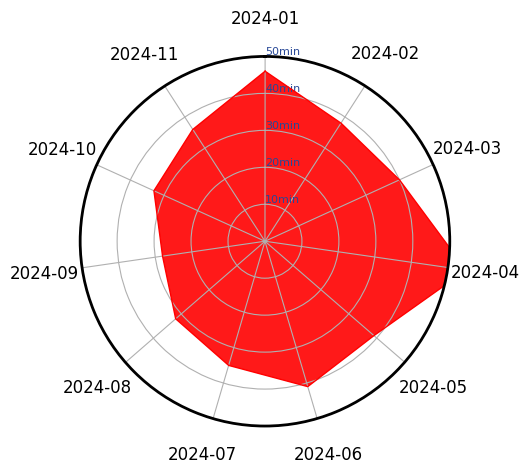

In [209]:
import plotly.express as px
average_duration_per_month['minute'] = average_duration_per_month['mean_duration'].dt.total_seconds() / 60
average_duration_per_month['minute'] = average_duration_per_month['minute'].astype(int)
average_duration_per_month['month'] = average_duration_per_month['month'].astype(str)

categories=list(average_duration_per_month['month'])
N = len(categories)
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * 3.14 for n in range(N)]
angles += angles[:1]
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
# If you want the first axis to be on top:
ax.set_theta_offset(3.14 / 2)
ax.set_theta_direction(-1)
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, size=12)
for label in ax.get_xticklabels():
    label.set_color("black")
    label.set_verticalalignment('center')
    label.set_horizontalalignment('center')
    label.set_position((0, -0.1))  # Déplacer chaque étiquette en ajustant le padding radial

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([10,20,30,40,50], ["10min","20min","30min","40min", "50min"], color="#284897", size=8)
plt.ylim(0,50)
# ------- PART 2: Add plots
# Name1
values=average_duration_per_month['minute'].tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Temps de résolution moyen", color='red')

ax.fill(angles, values, 'red', alpha=0.9)

ax.spines['polar'].set_color('black')  # Couleur de l'anneau extérieur
ax.spines['polar'].set_linewidth(2)  # Largeur de l'anneau

#plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

In [187]:
pb_resolve_df['duration'].sort_values(ascending=False)


411    0 days 09:56:46
1893   0 days 09:36:08
1440   0 days 09:33:46
831    0 days 08:31:10
638    0 days 08:29:36
             ...      
607    0 days 00:00:29
807    0 days 00:00:29
1789   0 days 00:00:29
1455   0 days 00:00:28
1372   0 days 00:00:22
Name: duration, Length: 1907, dtype: timedelta64[ns]

In [189]:
pb_resolve_df.iloc[1893]

id            0488b281-9b70-4f4f-b34e-27fc54368f1a
begin_date                     2024-01-03 20:44:06
end_date                       2024-01-04 06:20:14
duration                           0 days 09:36:08
label                                  panne train
month                                      2024-01
Name: 1893, dtype: object